## Constant from IV-characteristics : <font color = 'sky blue'> $n_e, T_e, T_-, I_{sat+}$ </font>
<font size="2">
    We use classical Langmuir probe method here to obtain constants listed above. <br><br>
    $n_e=\frac{I(V_p)}{eA} (\frac{2\pi m_e}{T_e})^{1/2} $ <br><br>
    $I(V_p)$ is probe current at plasma potential, $A$ is probe surface area.<br><br>
    $T_e = \frac{4\sqrt{2m_e/e}}{3n_eA} \int_{0}^{-\infty} I''(V) {|V|}^{3/2} dV$ <br><br>
    We can get $I''(V)$ from second derivative and $I_{sat+}$ from most negative probe potential. $T_-$ would be given value. <br><br>
    
</font>

In [22]:
import numpy as np
from scipy.optimize import fsolve

ne  = 1
Te = 20
Tm = 1
Isatp = 4
init_alpha_0 = 2
init_r_sh = 0

## Iteration method : <font color = 'purple'> </font>
<font size = '2'>
    Initial value : <font color = 'sky blue'> $\alpha_{0,0} = 2, r_{sh,0} = 0$ </font><br><br>
    Constant value : <font color = 'sky blue'> $n_e, T_e, T_-, I_{sat+}, h_r$ </font><br><br>
    We can also define $\alpha_{s,0}$ by relation between $\alpha_0$ and $\alpha_s$<br><br>
    Update modified Bohm speed : $u_{B+,k}^* = \sqrt{\frac{e T_e}{m_+}}\sqrt{\frac{1+\alpha_{s,k-1}}{1+\gamma \alpha_{s,k-1}}}$<br><br>
    Update ion density : $n_{+,k} = \frac{I_{sat+}}{h_r S_{eff,k-1}e u_{B+,k}^*}$ (Bohm flux) <br><br>
    Update electronegativity : $\alpha_{0,k} = \frac{n_{+,k}}{n_e}-1$ <br><br>
    Update $\alpha_{s,k}$ : $\alpha_{0,k} = \alpha_{s,k} exp(-\frac{1}{2} (\frac{1+\alpha_{s,k}}{1+\gamma \alpha_{s,k}})(1-\gamma))$<br><br>
    Update positive ion current density : $J_{+,k} = h_r e n_{+,k}u_{B+,k}^*$ <br><br>
    Update $r_{sh}$ : $\frac{du}{dr} = \frac{eE}{m_+u(r)}, \frac{dE}{dr} = \frac{RJ_0}{r\epsilon_0u(r)}-\frac{E}{r}$ <br><br>
    Update effective ion collecting area : $S_{eff,k} = 2\pi s_k l$ where $s_k = r_{sh,k} + a $<br><br> 
    From this point, all values are re-injected to Modified Bohm speed equation for new iteration. <br><br>
    Iteration is stopped when $|\alpha_{0,k-1}-\alpha_{0,k}|<0.01\alpha_{0,k}$ <br><br>
    $S_{eff}(V) = 2\pi l r_{sh}(V) + 2\pi r_{sh}^2(V)$ <br><br>
</font>

In [23]:
class iter_method:
    def __init__(self, ne, Te, Tm, Isatp):
        self.ne = ne
        self.Te = Te
        self.Tm = Tm
        self.Isatp = Isatp
        self.gamma = Te/Tm
        
    def alpha_search(self, alpha_0):
        func = lambda alpha_s : alpha_0 - alpha_s*np.exp(-0.5*((1+alpha_s)/(1+self.gamma*alpha_s))*(1-self.gamma))
        alpha_s_initial_guess = [1e-5,1e-4,1e-3,1e-2,1e-1,1,1e1,1e2]
        self.alpha_s = np.unique(np.round(fsolve(func, alpha_s_initial_guess),12))
        
    def iteration(self):
        self.alpha_0k = self.alpha_0
        iter_count = 0
        while(abs(self.alpha_0 - self.alpha_0k) < 0.01*self.alpha_0):
            iter_count += 1
            
            pass

In [24]:
sample = iter_method(ne, Te, Tm, Isatp)

In [25]:
sample.alpha_search(init_alpha_0)
print(sample.alpha_s)

[1.53907661e-04 1.90519245e-01 6.56932481e-01]


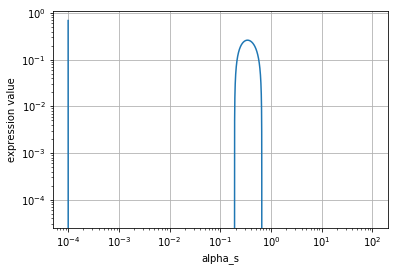

The solution is alpha_s = : [1.53907661e-04 1.90519245e-01 6.56932481e-01]


In [18]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import fsolve

# Define the expression whose roots we want to find

alpha_0 = 2
gamma = 20

def func(alpha_s):
    return alpha_0 - alpha_s*np.exp(-0.5*((1+alpha_s)/(1+gamma*alpha_s))*(1-gamma))

# Use the numerical solver to find the roots

alpha_s_initial_guess = [1e-5,1e-4,1e-3,1e-2,1e-1,1,1e1,1e2]
alpha_s_solution = np.unique(np.round(fsolve(func, alpha_s_initial_guess),12))

print ("The solution is alpha_s = :" ,alpha_s_solution)

In [47]:
#Bisection Demo (slow)
import math

def rootsearch(f,a,b,dx):
    x1 = a; f1 = f(a)
    x2 = a + dx; f2 = f(x2)
    while f1*f2 > 0.0:
        if x1 >= b:
            return None,None
        x1 = x2; f1 = f2
        x2 = x1 + dx; f2 = f(x2)
    return x1,x2

def bisect(f,x1,x2,switch=0,epsilon=1.0e-8):
    f1 = f(x1)
    if f1 == 0.0:
        return x1
    f2 = f(x2)
    if f2 == 0.0:
        return x2
    if f1*f2 > 0.0:
        print('Root is not bracketed')
        return None
    n = int(math.ceil(math.log(abs(x2 - x1)/epsilon)/math.log(2.0)))
    for i in range(n):
        x3 = 0.5*(x1 + x2); f3 = f(x3)
        if (switch == 1) and (abs(f3) >abs(f1)) and (abs(f3) > abs(f2)):
            return None
        if f3 == 0.0:
            return x3
        if f2*f3 < 0.0:
            x1 = x3
            f1 = f3
        else:
            x2 =x3
            f2 = f3
    return (x1 + x2)/2.0

def roots(f, a, b, eps=1e-5):
    print ('The roots on the interval [%f, %f] are:' % (a,b))
    while 1:
        x1,x2 = rootsearch(f,a,b,eps)
        if x1 != None:
            a = x2
            root = bisect(f,x1,x2,1)
            if root != None:
                pass
                print (round(root,-int(math.log(eps, 10))))
        else:
            print ('\nDone')
            break
alpha_0 = 2
gamma = 5 
f=lambda alpha_s:alpha_0 - alpha_s*np.exp(-0.5*((1+alpha_s)/(1+gamma*alpha_s))*(1-gamma))
roots(f, 1e-4, 1e2)

The roots on the interval [0.000100, 100.000000] are:
1.03452

Done
